# Lab 3: Quantitized Model Benchmarking Efficiency in Feed-Forward Neural Networks.

**Team Cyclops**


In [1]:
# Below is the code for building the network

import torch
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import torchvision
from PIL import Image
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

trainPath = "./MNIST/mnist_train.csv"
testPath = "./MNIST/mnist_test.csv"

Device:  cpu


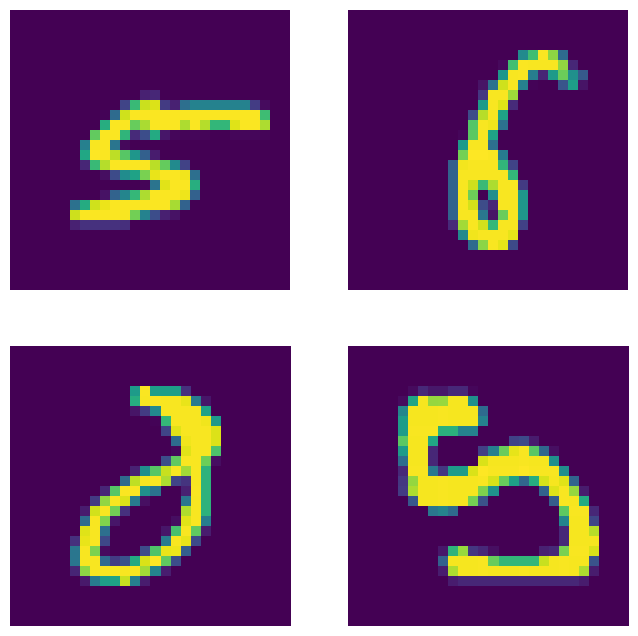

In [2]:
# Define Dataloader
class MNISTDataset(torch.utils.data.Dataset):

    def __init__(self, fileName: str, transform = None):
        self.X_Data, self.Y_Data = [], []

        with open(fileName, mode = 'r') as f:

            csvreader = csv.reader(f)

            for line in csvreader:
                row = list(map(int, line))

                pixels = row[1:]
                label = row[0]

                pixels = (pixels - np.mean(pixels, axis = 0))/np.std(pixels, axis = 0)

                self.X_Data.append(pixels)
                self.Y_Data.append(label)

        self.transform = transform
        self.length = len(self.Y_Data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):

        X_tensor = torch.FloatTensor(self.X_Data[idx])
        Y_tensor = torch.tensor(self.Y_Data[idx])

        if self.transform:
            X_tensor = self.transform(X_tensor)

        return X_tensor, Y_tensor
    


trainMNIST  = MNISTDataset(trainPath, None)
testMNIST = MNISTDataset(testPath, None)

train_loader_temp = torch.utils.data.DataLoader(
    dataset = trainMNIST,
    batch_size = 64,
    shuffle = True
)

test_loader_temp = torch.utils.data.DataLoader(
    dataset = testMNIST,
    batch_size = 64,
    shuffle = True
)


r, c = [2, 2]
fig, ax = plt.subplots(r, c, figsize= (8, 8))

k = 0

for data in train_loader_temp:
    x, y = data
    
    for i in range(r):
        for j in range(c):
            img = x[k].numpy().reshape(28, 28)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k += 1

    break

del train_loader_temp, test_loader_temp

In [3]:
def trainLoop(inputModel, inputOptimizer, inputCriterion, dataloader, num_epochs = 2):

    startTime = time.time()

    # Looping over the epochs
    for epoch in range(num_epochs):

        # Putting the model in training loop
        inputModel.train()

        runningLoss = 0

        for pixels, labels in dataloader:

            # Zeroing the gradients
            inputOptimizer.zero_grad()

            # Forward Pass
            outputs = inputModel(pixels)
            loss = inputCriterion(outputs, labels)

            # Backprop
            loss.backward()
            inputOptimizer.step()

            runningLoss += loss.item()

        epochLoss = runningLoss/len(dataloader)
        # print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {epochLoss:.4f}')
    endTime = time.time()
    return (endTime - startTime)/num_epochs


def testLoop(inputModel, dataloader, batch_size):

    startTime = time.time()

    correct_predictions = 0
    total_predicitions = 0

    # Putting the model in evaluation mode
    inputModel.eval()

    # Ensuring no gradients are calculated
    with torch.no_grad():
        for pixels, numbers in dataloader:
            
            # Forward Pass
            outputs = inputModel(pixels)

            # Inference 
            correct_predictions += torch.sum(torch.argmax(outputs, dim = 1) == numbers).item()
            total_predicitions += len(numbers)


    accuracy = 100 * correct_predictions/total_predicitions
    endTime = time.time()
    return accuracy, (endTime - startTime)/(len(dataloader)*batch_size)



# Computing the Parameters in the model
def getParams(inputModel):
    
    model_size = 0
    for f in inputModel.parameters():
        if f.requires_grad:

            model_size += f.numel()

    return model_size

# Computing FLOPS
def getFLOPS(inputModel):

    flops = 0

    for f in inputModel.parameters():
        if f.requires_grad:

            if f.ndim == 1:
                flops += 2*f.shape[0]
            else:
                flops += 2*f.shape[0]*f.shape[1]

    return flops

def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (MB):', size/1e6)
    os.remove('temp.p')
    return size

In [4]:
train_loader = torch.utils.data.DataLoader(
    dataset = trainMNIST,
    batch_size = 64,
    shuffle = True
)

test_loader_1 = torch.utils.data.DataLoader(
    dataset = testMNIST,
    batch_size = 1,
    shuffle = True
)

test_loader_64 = torch.utils.data.DataLoader(
    dataset = testMNIST,
    batch_size = 64,
    shuffle = True
)

# BaseLine Model
class BaselineMLP(torch.nn.Module):

    def __init__(self, input_size = 784, output_size = 10, hidden_size = 1024):

        super(BaselineMLP, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),

            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),

            torch.nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):

        out = self.model(x)
        return out

# Model Training

In [5]:
baseline_model  = BaselineMLP(input_size = 784, output_size = 10, hidden_size = 1024).to(device)
baseline_criterion = torch.nn.CrossEntropyLoss()
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr = 0.001)

predTime = trainLoop(inputModel = baseline_model, inputOptimizer = baseline_optimizer, inputCriterion = baseline_criterion, dataloader = train_loader, num_epochs = 2)
print("Training time per epoch: ", predTime)

print("Model precision: fp32")
model_size_storgae = print_size_of_model(baseline_model)

model_size_params = getParams(baseline_model)
print("Number of parameters: {}".format(model_size_params))

Training time per epoch:  7.873818516731262
Model precision: fp32
model:    	 Size (MB): 7.456639
Number of parameters: 1863690


### Batch Size 1

In [6]:
# Batch Size 1 experiments
all_accuracies_1, all_inference_1 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = baseline_model, dataloader = test_loader_1, batch_size = 1)

    all_accuracies_1.append(baselineAcc)
    all_inference_1.append(baselineInf)
    
    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)


print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_1).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_1).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_1).std ()))

del all_accuracies_1, all_inference_1


Run- 1
Inference Time:  0.00014962770938873292
Testing Accuracy:  97.37

Run- 2
Inference Time:  0.00012966232299804688
Testing Accuracy:  97.37

Run- 3
Inference Time:  0.0001537252902984619
Testing Accuracy:  97.37

Run- 4
Inference Time:  0.00012429850101470946
Testing Accuracy:  97.37

Run- 5
Inference Time:  0.0001420781135559082
Testing Accuracy:  97.37


Average Accuracy: 97.37
Average Inference Time: 0.00013987838745117186
Std Inference Time: 1.1302438904270402e-05


### Batch Size 64

In [7]:
# Batch Size 64 experiments
all_accuracies_64, all_inference_64 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = baseline_model, dataloader = test_loader_64, batch_size = 64)

    all_accuracies_64.append(baselineAcc)
    all_inference_64.append(baselineInf)
    
    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)

print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_64).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_64).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_64).std ()))

del all_accuracies_64, all_inference_64


Run- 1
Inference Time:  2.4155565318028638e-05
Testing Accuracy:  97.37

Run- 2
Inference Time:  1.6190182821006532e-05
Testing Accuracy:  97.37

Run- 3
Inference Time:  1.7612152228689496e-05
Testing Accuracy:  97.37

Run- 4
Inference Time:  1.804312323309054e-05
Testing Accuracy:  97.37

Run- 5
Inference Time:  2.2014614882742524e-05
Testing Accuracy:  97.37


Average Accuracy: 97.37
Average Inference Time: 1.9603127696711548e-05
Std Inference Time: 2.9861596979987197e-06


# Dynamic quantization in PyTorch

In [8]:
from torch.quantization.quantize_fx import prepare_fx, prepare_qat_fx, convert_fx

## Float 16 Quantization (Will not run on Mac M1, use Colab)

In [9]:
# torch.backends.quantized.engine = 'fbgemm'
# model_dynamic_float_16 = torch.quantization.quantize_dynamic(baseline_model, {torch.nn.Linear}, dtype=torch.float16)

# print("Model precision: float16")
# model_size_storgae = print_size_of_model(model_dynamic_float_16)

### Batch Size 1

In [10]:
# # Batch Size 1 experiments
# all_accuracies_float16_1, all_inference_float16_1 = [], []
# for i in range(5):
#     print("\nRun-", (i + 1))
#     baselineAcc, baselineInf = testLoop(inputModel = model_dynamic_float_16, dataloader = test_loader_1, batch_size = 1)

#     all_accuracies_float16_1.append(baselineAcc)
#     all_inference_float16_1.append(baselineInf)
    
#     print("Inference Time: ", baselineInf)
#     print("Testing Accuracy: ", baselineAcc)


# print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_float16_1).mean()))
# print("Average Inference Time: {}".format(np.array(all_inference_float16_1).mean()))
# print("Std Inference Time: {}".format(np.array(all_inference_float16_1).std ()))

# del all_accuracies_float16_1, all_inference_float16_1 

### Batch Size 64

In [11]:
# # Batch Size 64 experiments
# all_accuracies_float16_64, all_inference_float16_64 = [], []
# for i in range(5):
#     print("\nRun-", (i + 1))
#     baselineAcc, baselineInf = testLoop(inputModel = model_dynamic_float_16, dataloader = test_loader_64, batch_size = 64)

#     all_accuracies_float16_64.append(baselineAcc)
#     all_inference_float16_64.append(baselineInf)
    
#     print("Inference Time: ", baselineInf)
#     print("Testing Accuracy: ", baselineAcc)

# print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_float16_64).mean()))
# print("Average Inference Time: {}".format(np.array(all_inference_float16_64).mean()))
# print("Std Inference Time: {}".format(np.array(all_inference_float16_64).std ()))

# del all_accuracies_float16_64, all_inference_float16_64

# q INT8 Quantization

In [12]:
torch.backends.quantized.engine = 'qnnpack'
model_dynamic_q_int8 = torch.quantization.quantize_dynamic(baseline_model, {torch.nn.Linear}, dtype=torch.qint8)

print("Model precision: qint8")
model_size_storgae = print_size_of_model(model_dynamic_q_int8)

Model precision: qint8
model:    	 Size (MB): 1.873623


### Batch Size 1

In [13]:
# Batch Size 1 experiments
all_accuracies_qint8_1, all_inference_qint8_1 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = model_dynamic_q_int8, dataloader = test_loader_1, batch_size = 1)

    all_accuracies_qint8_1.append(baselineAcc)
    all_inference_qint8_1.append(baselineInf)
    
    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)


print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_qint8_1).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_qint8_1).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_qint8_1).std ()))

del all_accuracies_qint8_1, all_inference_qint8_1 


Run- 1


[W qlinear_dynamic.cpp:247] Warning: Currently, qnnpack incorrectly ignores reduce_range when it is set to true; this may change in a future release. (function operator())


Inference Time:  0.0005500967979431153
Testing Accuracy:  97.4

Run- 2
Inference Time:  0.00040484278202056884
Testing Accuracy:  97.4

Run- 3
Inference Time:  0.00033933110237121584
Testing Accuracy:  97.4

Run- 4
Inference Time:  0.0003362049102783203
Testing Accuracy:  97.4

Run- 5
Inference Time:  0.00034634108543395994
Testing Accuracy:  97.4


Average Accuracy: 97.4
Average Inference Time: 0.00039536333560943605
Std Inference Time: 8.13324237086491e-05


### Batch Size 64

In [14]:
# Batch Size 64 experiments
all_accuracies_qint8_64, all_inference_qint8_64 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = model_dynamic_q_int8, dataloader = test_loader_64, batch_size = 64)

    all_accuracies_qint8_64.append(baselineAcc)
    all_inference_qint8_64.append(baselineInf)
    
    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)

print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_qint8_64).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_qint8_64).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_qint8_64).std ()))

del all_accuracies_qint8_64, all_inference_qint8_64


Run- 1
Inference Time:  3.164479876779447e-05
Testing Accuracy:  97.41

Run- 2
Inference Time:  2.558489039445379e-05
Testing Accuracy:  97.42

Run- 3
Inference Time:  2.5975903508010183e-05
Testing Accuracy:  97.4

Run- 4
Inference Time:  2.7317957134003852e-05
Testing Accuracy:  97.4

Run- 5
Inference Time:  3.455353865198269e-05
Testing Accuracy:  97.39


Average Accuracy: 97.404
Average Inference Time: 2.9015417691248995e-05
Std Inference Time: 3.506364640734996e-06


# Static Quantization (q INT8)

In [15]:
from torch.quantization.quantize_fx import prepare_fx, prepare_qat_fx, convert_fx
qconfig_mapping = torch.ao.quantization.get_default_qconfig_mapping("qnnpack")
quantized_model = torch.ao.quantization.quantize_fx.prepare_fx(baseline_model, qconfig_mapping, torch.randn(784, 1000))

def calibrate(model, dataloader):
    model.eval()
    with torch.no_grad():
        for input in dataloader:
            model(input[0])

calibrate(quantized_model, train_loader)
static_quantized_model_int8 = torch.ao.quantization.quantize_fx.convert_fx(quantized_model)

print("Model precision: qint8")
model_size_storgae = print_size_of_model(model_dynamic_q_int8)

Model precision: qint8
model:    	 Size (MB): 1.873623


### Batch Size 1

In [16]:
# Batch Size 1 experiments
all_accuracies_qint8_1, all_inference_qint8_1 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = static_quantized_model_int8, dataloader = test_loader_1, batch_size = 1)

    all_accuracies_qint8_1.append(baselineAcc)
    all_inference_qint8_1.append(baselineInf)
    
    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)

print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_qint8_1).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_qint8_1).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_qint8_1).std ()))

del all_accuracies_qint8_1, all_inference_qint8_1


Run- 1
Inference Time:  0.0003821171045303345
Testing Accuracy:  97.39

Run- 2
Inference Time:  0.00031534719467163087
Testing Accuracy:  97.39

Run- 3
Inference Time:  0.0002933868169784546
Testing Accuracy:  97.39

Run- 4
Inference Time:  0.0002848755121231079
Testing Accuracy:  97.39

Run- 5
Inference Time:  0.00029399459362030027
Testing Accuracy:  97.39


Average Accuracy: 97.39
Average Inference Time: 0.0003139442443847656
Std Inference Time: 3.553897779178385e-05


### Batch Size 64

In [17]:
# Batch Size 64 experiments
all_accuracies_qint8_64, all_inference_qint8_64 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = static_quantized_model_int8, dataloader = test_loader_64, batch_size = 64)

    all_accuracies_qint8_64.append(baselineAcc)
    all_inference_qint8_64.append(baselineInf)
    
    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)

print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_qint8_64).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_qint8_64).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_qint8_64).std ()))

del all_accuracies_qint8_64, all_inference_qint8_64


Run- 1
Inference Time:  3.7731899387517554e-05
Testing Accuracy:  97.39

Run- 2
Inference Time:  2.337014599210897e-05
Testing Accuracy:  97.39

Run- 3
Inference Time:  2.4947343738215744e-05
Testing Accuracy:  97.39

Run- 4
Inference Time:  2.570341157305772e-05
Testing Accuracy:  97.39

Run- 5
Inference Time:  2.0976611383401663e-05
Testing Accuracy:  97.39


Average Accuracy: 97.39
Average Inference Time: 2.654588241486033e-05
Std Inference Time: 5.8222700105925355e-06
